In [1]:
import regex
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import morfeusz2
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from spacy.tokenizer import Tokenizer
from nlp_common.acts_reader import ActsReader
from collections import Counter
from itertools import chain

### Data preparation

Data used in the exercise comes from two sources: set of polish bills (from previous exercies) and sgjp dictionary. The second one is loaded to elasticsearch in the attached script (main.py).

In [2]:
acts_reader = ActsReader('../ustawy') 
bills = [ text for _, _, text in acts_reader.all_acts()]

### Remove HTML tags

In [3]:
html_regex = regex.compile(r'<\/?[^>]*>', regex.IGNORECASE)
for bill in bills:
    matches = html_regex.findall(bill)
    for match in matches:
        print(match)

< < tajne >


Nothing to clean 🤷

### Tokenize

In [4]:
new_line_re = regex.compile(r'\n+')
bills = [new_line_re.sub(' ', bill) for bill in bills]

In [5]:
nlp = spacy.load("pl_core_news_sm")
prefix_re = regex.compile(r'''^[\[\("'\„]''')
suffix_re = regex.compile(r'''[\]\)"'\:\;\,\.]+$''')
nlp.tokenizer = Tokenizer(nlp.vocab, prefix_search=prefix_re.search, suffix_search=suffix_re.search)

In [6]:
bill_docs = list(nlp.tokenizer.pipe(bills))

### Word counters

In [7]:
ctrs = [ Counter([d.text.lower() for d in doc]) for doc in bill_docs ]

In [8]:
global_counter = Counter()
for ctr in ctrs:
    global_counter += ctr

In [9]:
len(global_counter)

72507

### Rank

In [10]:
# Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).
def reject(word):
    if len(word) < 2 or not regex.match(r'^\p{L}+$', word):
        return True
    return False

word_ctr_pairs = [ (word, global_counter[word]) for word in global_counter ]
word_ctr_pairs_without_rejected = filter(lambda w: not reject(w[0]), word_ctr_pairs)
word_ctr_pairs_sorted = sorted(word_ctr_pairs_without_rejected, key=lambda w: (-w[1], w[0]))
word_ctr_pairs_ranked = map(lambda wi: (wi[1][0], wi[1][1], wi[0]+1), enumerate(word_ctr_pairs_sorted))
df = pd.DataFrame(word_ctr_pairs_ranked, columns=['word', '#occurences', 'rank'])

In [11]:
df

,word,#occurences,rank
0,art,83586,1
1,do,60724,2
2,ust,53367,3
3,na,50639,4
4,się,45864,5
...,...,...,...
54334,żądanego,1,54335
54335,żądaniami,1,54336
54336,żądano,1,54337
54337,żądany,1,54338


### Plot

<AxesSubplot:xlabel='rank', ylabel='#occurences'>

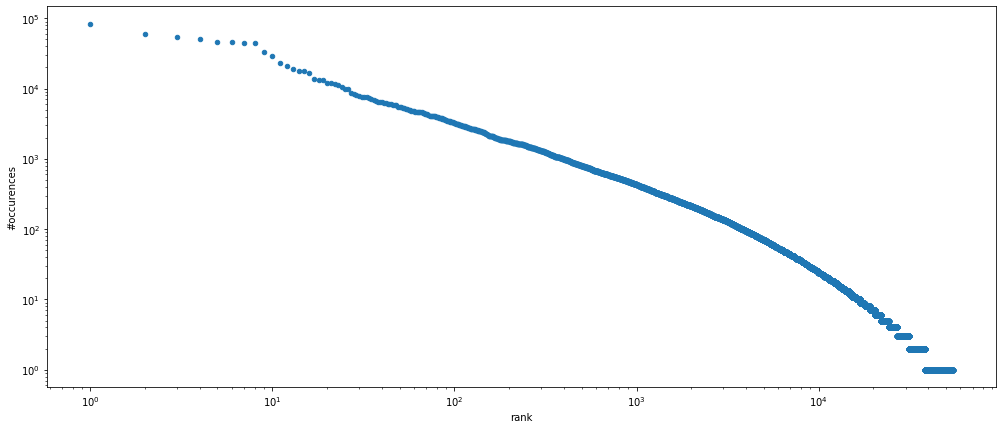

In [12]:
df.plot.scatter(x='rank', y='#occurences', logx=True, logy=True, figsize=(17,7))

### Words that not appear in dictionary

In [13]:
morf = morfeusz2.Morfeusz()
df['in_morfeusz'] = df['word'].apply(lambda x: morf.analyse(x)[0][2][2] != 'ign')

#### Top 30 words with the highest ranks that do not belong to the dictionary

In [14]:
top_unknown_df = df[df['in_morfeusz'] == False][:30]
top_unknown_df

,word,#occurences,rank,in_morfeusz
6,poz,45009,7,False
367,późn,1065,368,False
830,str,514,831,False
1427,gmo,298,1428,False
2018,sww,211,2019,False
2196,skw,193,2197,False
2479,ex,167,2480,False
2551,ike,162,2552,False
3347,remediacji,119,3348,False
3502,zm,112,3503,False


#### 30 random words (i.e. shuffle the words) with 3-7 occurrences that do not belong to the dictionary.

In [15]:
random_unknown_df = df[(df['in_morfeusz'] == False) & (df['#occurences'] >= 3) & (df['#occurences'] <= 7)].sample(n=30)
random_unknown_df

,word,#occurences,rank,in_morfeusz
19435,milirównoważników,7,19436,False
26051,ru,4,26052,False
30396,wanej,3,30397,False
27828,instrumentalistyki,3,27829,False
25106,nawozo,4,25107,False
21078,otrzymywan,6,21079,False
27095,agaricus,3,27096,False
21538,syloe,6,21539,False
24750,jw,4,24751,False
25779,protokoł,4,25780,False


### Finding closest word with Levenshtein metric

In [16]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        total = te-ts
        print(f'func:{f.__name__} args:[{args}] took: {total} sec')
        return result, total
    return wrap

In [17]:
A = 'aąbcćdeęfghijklłmnńoóprsśtuwyzżź'

def generate_additions(word):
    for i in range(len(word)):
        pref = word[:i]
        suf = word[i:]
        for a in A:
            yield pref + a + suf 

def generate_deletions(word):
    for i in range(len(word)):
        yield word[:i] + word[i+1:]
    
def generate_swaps(word):
    for i in range(len(word)):
        pref = word[:i]
        suf = word[i+1:]
        for a in A:
            if a != word[i]:
                yield pref + a + suf

c=0
def check_in_morf(word):
#     cac= morf.analyse(word)[0][2][2] != 'ign'
    global c
    c += 1
#     if c%10000 == 0:
#         print(c)
    return morf.analyse(word)[0][2][2] != 'ign'
    
@timing    
def find_closest(word, max_d=2):
    # bfs
    Q = [(word, 0)]
    vis = { word }

    while len(Q) > 0:
        w, d = Q.pop(0)
        for wa in chain(generate_additions(w), generate_deletions(w), generate_swaps(w)):
            if check_in_morf(wa):
                return wa
            if not wa in vis and d + 1 < max_d:
                Q.append((wa, d+1))
                vis.add(wa)
    
    return None


print(find_closest('rytorialnego'))
print(c)

func:find_closest args:[('rytorialnego',)] took: 0.12361907958984375 sec
('terytorialnego', 0.12361907958984375)
5786


In [18]:
top_unknown_df['possible_correction'], top_unknown_df['correction_time'] = zip(*top_unknown_df['word'].apply(lambda x: find_closest(x)))
random_unknown_df['possible_correction'], random_unknown_df['correction_time'] = zip(*random_unknown_df['word'].apply(lambda x: find_closest(x)))

func:find_closest args:[('poz',)] took: 0.0014162063598632812 sec
func:find_closest args:[('późn',)] took: 0.16574740409851074 sec
func:find_closest args:[('str',)] took: 4.124641418457031e-05 sec
func:find_closest args:[('gmo',)] took: 0.0009555816650390625 sec
func:find_closest args:[('sww',)] took: 0.0017991065979003906 sec
func:find_closest args:[('skw',)] took: 0.0006144046783447266 sec
func:find_closest args:[('ex',)] took: 0.00044608116149902344 sec
func:find_closest args:[('ike',)] took: 0.0003676414489746094 sec
func:find_closest args:[('remediacji',)] took: 0.0004646778106689453 sec
func:find_closest args:[('zm',)] took: 0.0002529621124267578 sec
func:find_closest args:[('rozdz',)] took: 0.005590677261352539 sec
func:find_closest args:[('ure',)] took: 9.036064147949219e-05 sec
func:find_closest args:[('itp',)] took: 0.0017778873443603516 sec
func:find_closest args:[('kn',)] took: 0.0004200935363769531 sec
func:find_closest args:[('uke',)] took: 0.0017244815826416016 sec
func:

In [19]:
top_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time
6,poz,45009,7,False,płoz,0.001416
367,późn,1065,368,False,spórn,0.165747
830,str,514,831,False,astr,0.000041
1427,gmo,298,1428,False,gamo,0.000956
2018,sww,211,2019,False,sw,0.001799
2196,skw,193,2197,False,sakw,0.000614
2479,ex,167,2480,False,rex,0.000446
2551,ike,162,2552,False,mike,0.000368
3347,remediacji,119,3348,False,premediacji,0.000465
3502,zm,112,3503,False,izm,0.000253


In [20]:
random_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time
19435,milirównoważników,7,19436,False,midirównoważników,0.018447
26051,ru,4,26052,False,bru,0.000076
30396,wanej,3,30397,False,cwanej,0.000186
27828,instrumentalistyki,3,27829,False,instrumentalistki,0.012082
25106,nawozo,4,25107,False,nawęzo,0.004879
21078,otrzymywan,6,21079,False,otrzymywać,0.011702
27095,agaricus,3,27096,False,None,5.243557
21538,syloe,6,21539,False,sylce,0.006524
24750,jw,4,24751,False,jaw,0.001025
25779,protokoł,4,25780,False,prookoł,0.008047


### Elastic search fuziness

In [21]:
client = Elasticsearch("http://localhost:9200")

In [22]:
@timing
def find_closest_elastic(word):
    s = Search(using=client, index="sgjp")\
        .query('match', word = { 'query': word, 'fuzziness': 2 })   

    response = s.execute()

    if len(response) == 0:
        return None
    return response[0].word

find_closest_elastic('rytorialnego')

func:find_closest_elastic args:[('rytorialnego',)] took: 0.021126270294189453 sec


('terytorialnego', 0.021126270294189453)

In [23]:
top_unknown_df['possible_correction_elastic'], top_unknown_df['correction_time_elastic'] = zip(*top_unknown_df['word'].apply(lambda x: find_closest_elastic(x)))
random_unknown_df['possible_correction_elastic'], random_unknown_df['correction_time_elastic'] = zip(*random_unknown_df['word'].apply(lambda x: find_closest_elastic(x)))

func:find_closest_elastic args:[('poz',)] took: 0.009909391403198242 sec
func:find_closest_elastic args:[('późn',)] took: 0.010178327560424805 sec
func:find_closest_elastic args:[('str',)] took: 0.009995222091674805 sec
func:find_closest_elastic args:[('gmo',)] took: 0.012282848358154297 sec
func:find_closest_elastic args:[('sww',)] took: 0.009494781494140625 sec
func:find_closest_elastic args:[('skw',)] took: 0.009645223617553711 sec
func:find_closest_elastic args:[('ex',)] took: 0.008205652236938477 sec
func:find_closest_elastic args:[('ike',)] took: 0.008690834045410156 sec
func:find_closest_elastic args:[('remediacji',)] took: 0.01886773109436035 sec
func:find_closest_elastic args:[('zm',)] took: 0.008559703826904297 sec
func:find_closest_elastic args:[('rozdz',)] took: 0.010908126831054688 sec
func:find_closest_elastic args:[('ure',)] took: 0.009797334671020508 sec
func:find_closest_elastic args:[('itp',)] took: 0.00849294662475586 sec
func:find_closest_elastic args:[('kn',)] took

In [24]:
top_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
6,poz,45009,7,False,płoz,0.001416,poz,0.009909
367,późn,1065,368,False,spórn,0.165747,Późna,0.010178
830,str,514,831,False,astr,0.000041,str,0.009995
1427,gmo,298,1428,False,gamo,0.000956,GMC,0.012283
2018,sww,211,2019,False,sw,0.001799,Saw,0.009495
2196,skw,193,2197,False,sakw,0.000614,PKW,0.009645
2479,ex,167,2480,False,rex,0.000446,EP,0.008206
2551,ike,162,2552,False,mike,0.000368,IKE-ach,0.008691
3347,remediacji,119,3348,False,premediacji,0.000465,repudiacji,0.018868
3502,zm,112,3503,False,izm,0.000253,zm,0.008560


In [25]:
random_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
19435,milirównoważników,7,19436,False,midirównoważników,0.018447,None,0.014362
26051,ru,4,26052,False,bru,0.000076,mru-mru,0.018756
30396,wanej,3,30397,False,cwanej,0.000186,Ważnej,0.011196
27828,instrumentalistyki,3,27829,False,instrumentalistki,0.012082,instrumentalistki,0.013410
25106,nawozo,4,25107,False,nawęzo,0.004879,Nawoza,0.015946
21078,otrzymywan,6,21079,False,otrzymywać,0.011702,otrzymywana,0.012377
27095,agaricus,3,27096,False,None,5.243557,None,0.011382
21538,syloe,6,21539,False,sylce,0.006524,Sylce,0.013193
24750,jw,4,24751,False,jaw,0.001025,jw,0.010957
25779,protokoł,4,25780,False,prookoł,0.008047,protokołu,0.014376


### Conclusion

In [26]:
def xor_con_eq_0(df):
    not_none_corr = (df['possible_correction'] != None)
    none_corr = (df['possible_correction'] == None)
    not_none_corr_elastic = (df['possible_correction_elastic'] != None)
    none_corr_elastic = (df['possible_correction_elastic'] == None)

    return len(df[(not_none_corr & none_corr_elastic) | (none_corr & not_none_corr_elastic)])

print(f'Not found correction by exactly one of methods (top): {xor_con_eq_0(top_unknown_df)}')
print(f'Not found correction by exactly one of methods (random): {xor_con_eq_0(random_unknown_df)}')

Not found correction by exactly one of methods (top): 0
Not found correction by exactly one of methods (random): 0


We might think that there should never be a case in which exactly one of proposed correction is None. It is not true. Examples are: biobójczych, interkalibracyjnych. Corrections are found by levenshtein method and not by elastic. It happened because the corrections proposed by the first algorithm are not in the dictionary provided by morfeusz, but morfeusz.analyze method can find them.

<AxesSubplot:>

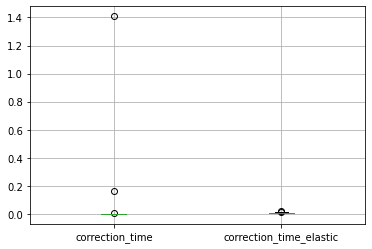

In [27]:
top_unknown_df.boxplot(column=['correction_time', 'correction_time_elastic'])

<AxesSubplot:>

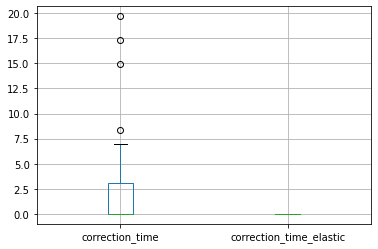

In [28]:
random_unknown_df.boxplot(column=['correction_time', 'correction_time_elastic'])

Comparing time of both methods we can notice that elastic is much more stable when it comes to execution time. In the manual method there are many outliers.\
Almost all solutions are different. Both method usually don't agree on the results.

Not always the solution found by algorithm seems to be correct for human. Example:\
word: naturalneg\
we expect: naturalnego\
levenshtein generation: naturalne\
elastic: naturalny

Distribution of the words on a chart without logaritmic scale would be hiperbolic. It means that there are a few words that appears very often, ex. 'ustawa'. It sounds reasonable because this word belengs to domain language. 

It is hard to determine if the word is true mispelling or unknown word. We have to go through each of the word to determine it.  